# Processing
In this notebook, we process the HDR captures to extract only the region of interest, i.e. the square region in the image that bounds the captured sphere.

In [15]:
import os
os.environ['OPENCV_IO_ENABLE_OPENEXR'] = '1'
import imageio
import cv2
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
imageio.plugins.freeimage.download()

# Please ignore the deprecation warning.

In [40]:
# Loading paths
from pathlib import Path
import os

# Set the correct current working directory using the current execution environment
script_dir = Path(__file__).parent if '__file__' in globals() else Path().resolve()
os.chdir(script_dir)

data_dir = Path("ru/HDR")
angles = [5, 20, 35, 50, 65, 80, 95, 110, 135, 150, 165, 175]  # The angles for your images
paths = [data_dir / f"angle_{angle}.exr" for angle in angles]

# Assertion to check paths
assert len(paths) > 3, "Assertion failed: The number of paths is too small."
assert all(p.exists() for p in paths), "Assertion failed: Not all paths exist."


In [31]:
# Calibration factor computed using a spectralon
calibration_factor = np.array([0.4648601,  0.81600523, 17.736147 ])

C:\Users\usman\AppData\Local\Temp\ipykernel_40876\1045041388.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  hdr = (imageio.imread(paths[idx]) * calibration_factor).astype(np.float32)


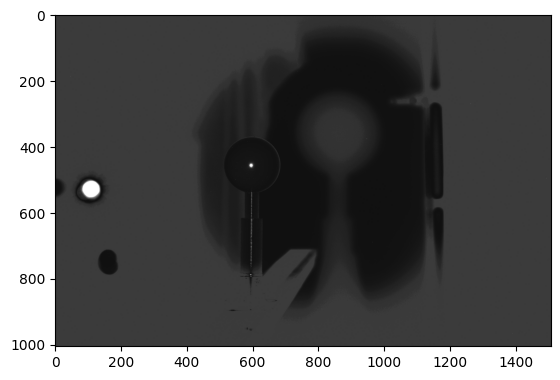

In [32]:
# Find one image in which to mark the circle.

idx =  0 # Select one idx where the whole sphere is clearly visible so we can find the bounding box
hdr = (imageio.imread(paths[idx]) * calibration_factor).astype(np.float32)
img8 = np.clip(np.repeat(np.mean(hdr, axis=-1, keepdims=True), 3, axis=-1), 0, 0.2)
img8 = (img8 / img8.max() * 255).astype(np.uint8)
scale = 0.25
width = int(img8.shape[1] * scale)
height = int(img8.shape[0] * scale)
img8 = cv2.resize(img8, (width, height), interpolation = cv2.INTER_AREA)
plt.imshow(img8)

In [33]:
# We show the image on the screen.
# Use right click to mark the pixels in the image on the circumference of the sphere/circle.
# Mark about 5 to 10 pixels
img = np.copy(img8)
points = []
def click_event(event, x, y, flags, param):
    if event == cv2.EVENT_RBUTTONDOWN:
        print(x,",",y)
        points.append((x, y))
        img[y, x, :] = [255, 0, 0]
        cv2.imshow("image", img)

cv2.namedWindow("image", cv2.WINDOW_GUI_NORMAL)
cv2.imshow("image", img)
cv2.setMouseCallback("image", click_event)

wait_time = 1000
while cv2.getWindowProperty('image', cv2.WND_PROP_VISIBLE) >= 1:
    keyCode = cv2.waitKey(wait_time)
    if (keyCode & 0xFF) == ord("q"):
        cv2.destroyAllWindows()
        break
cv2.destroyAllWindows()

595 , 369
671 , 411
672 , 499
603 , 541
529 , 507
516 , 430
551 , 384


In [34]:
assert 5 <= len(points)

#### We now find the circle by solving a simple optimization problem

In [35]:
from scipy import optimize

points = np.array(points)

def circle_distance(center):
    # calculates the distance from all 2D points to the current center prediction
    return np.sqrt(((points - center) ** 2).sum(axis=-1))

def error(center):
    # Calculates the residuum between the distances and mean distance. In a perfect circle the residuum would be 0
    Ri = circle_distance(center)
    return Ri - Ri.mean()

In [36]:
# Using leastsq to optimize the center w.r.t the error function
center_initial = np.mean(points, axis=0)
center_optimized , ier = optimize.leastsq(error, center_initial)
print("Initial center", center_initial)
print("Optimized center", center_optimized)

Initial center [591.         448.71428571]
Optimized center [597.88414385 455.41728126]


In [37]:
nx, ny = np.round(center_optimized / scale).astype(int)
radius = np.round(circle_distance(center_optimized).mean() / scale).astype(int)

radius

343

#### Check that the crop tightly bounds the sphere

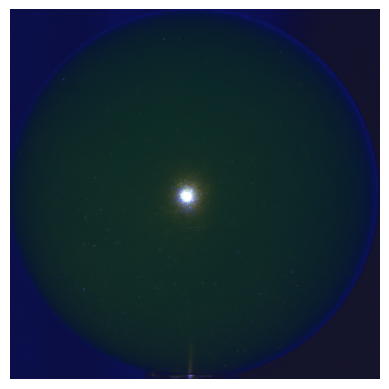

In [38]:
def linear_to_srgb(img):
	limit = 0.0031308
	return np.where(img > limit, 1.055 * (img ** (1.0 / 2.4)) - 0.055, 12.92 * img)

def plot_hdr(image, title=None):
    srgb = linear_to_srgb(image)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.imshow(np.clip(srgb, 0, 1))

hdr_crop = hdr[ny-radius:ny+radius, nx-radius:nx+radius, :]
plot_hdr(hdr_crop)

In [39]:
# Saving the crops
crop_dir = data_dir / "crops"
crop_dir.mkdir(exist_ok=True)

for angle, path in zip(angles, paths):
    hdr_image = (imageio.imread(path) * calibration_factor).astype(np.float32)
    hdr_crop = hdr_image[ny-radius:ny+radius, nx-radius:nx+radius, :]
    
    imageio.imsave(crop_dir / f'angle_{angle}.exr', hdr_crop)

C:\Users\usman\AppData\Local\Temp\ipykernel_40876\1543717458.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  hdr_image = (imageio.imread(path) * calibration_factor).astype(np.float32)
